In [1]:
from tueplots import bundles


# Linear Regression Tutorial

In [2]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update(bundles.icml2022())

## 1. Maximum Likelihood


Let us compute the maximum likelihood estimate for a given training set

In [3]:
## EDIT THIS FUNCTION
def max_lik_estimate(X, y):

    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)

    N, D = X.shape
    theta_ml = np.linalg.solve(X.T @ X, X.T @ y) ## <-- SOLUTION
    return theta_ml

Now, make a prediction using the maximum likelihood estimate that we just found

In [4]:
## EDIT THIS FUNCTION
def predict_with_estimate(Xtest, theta):

    # Xtest: K x D matrix of test inputs
    # theta: D x 1 vector of parameters
    # returns: prediction of f(Xtest); K x 1 vector

    prediction = Xtest @ theta ## <-- SOLUTION

    return prediction

In [5]:
## EDIT THIS FUNCTION
def poly_features(X, K):

    # X: inputs of size N x 1
    # K: degree of the polynomial
    # computes the feature matrix Phi (N x (K+1))

    X = X.flatten()
    N = X.shape[0]

    #initialize Phi
    Phi = np.zeros((N, K+1))

    # Compute the feature matrix in stages
    for k in range(K+1):
        Phi[:,k] = X**k ## <-- SOLUTION
    return Phi

In [6]:
## EDIT THIS FUNCTION
def nonlinear_features_maximum_likelihood(Phi, y):
    # Phi: features matrix for training inputs. Size of N x D
    # y: training targets. Size of N by 1
    # returns: maximum likelihood estimator theta_ml. Size of D x 1

    kappa = 1e-08 # 'jitter' term; good for numerical stability

    D = Phi.shape[1]

    # maximum likelihood estimate
    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I

    # maximum likelihood estimate
    C = scipy.linalg.cho_factor(PP)
    theta_ml = scipy.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y

    return theta_ml

## 2. Maximum A Posteriori Estimation

In [7]:
## EDIT THIS FUNCTION
def map_estimate_poly(Phi, y, sigma, alpha):
    # Phi: training inputs, Size of N x D
    # y: training targets, Size of D x 1
    # sigma: standard deviation of the noise
    # alpha: standard deviation of the prior on the parameters
    # returns: MAP estimate theta_map, Size of D x 1

    D = Phi.shape[1]

    # SOLUTION
    PP = Phi.T @ Phi + (sigma/alpha)**2 * np.eye(D)
    theta_map = scipy.linalg.solve(PP, Phi.T @ y)

    return theta_map

In [8]:
# define the function we wish to estimate later
def g(x, sigma):
    p = np.hstack([x**0, x**1, np.sin(x)])
    w = np.array([-1.0, 0.1, 1.0]).reshape(-1,1)
    return p @ w + sigma*np.random.normal(size=x.shape)

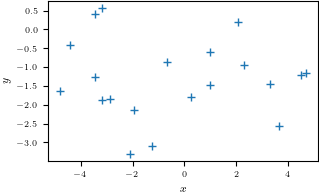

In [9]:
# Generate some data
sigma = 1.0 # noise standard deviation
alpha = 1.0 # standard deviation of the parameter prior
N = 20

np.random.seed(42)

X = (np.random.rand(N)*10.0 - 5.0).reshape(-1,1)
y = g(X, sigma) # training targets

plt.figure()
plt.plot(X, y, '+')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig('data.pdf')

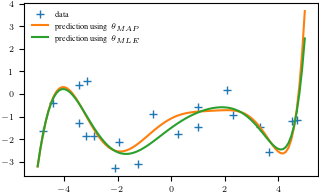

In [10]:
# get the MAP estimate
K = 8 # polynomial degree


# feature matrix
Phi = poly_features(X, K)

theta_map = map_estimate_poly(Phi, y, sigma, alpha)

# maximum likelihood estimate
theta_ml = nonlinear_features_maximum_likelihood(Phi, y)

Xtest = np.linspace(-5,5,100).reshape(-1,1)
ytest = g(Xtest, sigma)

Phi_test = poly_features(Xtest, K)
y_pred_map = Phi_test @ theta_map

y_pred_mle = Phi_test @ theta_ml

plt.figure()
plt.plot(X, y, '+')
plt.plot(Xtest, y_pred_map)
plt.plot(Xtest, y_pred_mle)

plt.legend(["data", r"prediction using $\theta_{MAP}$", r"prediction using $\theta_{MLE}$"], frameon = False)
plt.savefig('map_mle.pdf')

In [11]:
print(np.hstack([theta_ml, theta_map]))

[[-1.49712990e+00 -1.08154986e+00]
 [ 8.56868912e-01  6.09177023e-01]
 [-1.28335730e-01 -3.62071208e-01]
 [-7.75319509e-02 -3.70531732e-03]
 [ 3.56425467e-02  7.43090617e-02]
 [-4.11626749e-03 -1.03278646e-02]
 [-2.48817783e-03 -4.89363010e-03]
 [ 2.70146690e-04  4.24148554e-04]
 [ 5.35996050e-05  1.03384719e-04]]


## 3. Bayesian Linear Regression

In [12]:
# Test inputs
Ntest = 200
Xtest = np.linspace(-5, 5, Ntest).reshape(-1,1) # test inputs

prior_var = 2.0 # variance of the parameter prior (alpha^2). We assume this is known.
noise_var = 1.0 # noise variance (sigma^2). We assume this is known.

pol_deg = 3 # degree of the polynomial we consider at the moment

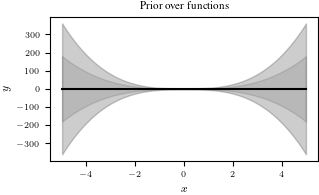

In [13]:
## EDIT THIS CELL

# compute the feature matrix for the test inputs
Phi_test = poly_features(Xtest, pol_deg) # N x (pol_deg+1) feature matrix SOLUTION

# compute the (marginal) prior at the test input locations
# prior mean
prior_mean = np.zeros((Ntest,1)) # prior mean <-- SOLUTION

# prior variance
full_covariance = Phi_test @ Phi_test.T * prior_var # N x N covariance matrix of all function values
prior_marginal_var =  np.diag(full_covariance)

# Let us visualize the prior over functions
plt.figure()
plt.plot(Xtest, prior_mean, color="k")

conf_bound1 = np.sqrt(prior_marginal_var).flatten()
conf_bound2 = 2.0*np.sqrt(prior_marginal_var).flatten()
conf_bound3 = 2.0*np.sqrt(prior_marginal_var + noise_var).flatten()
plt.fill_between(Xtest.flatten(), prior_mean.flatten() + conf_bound1,
             prior_mean.flatten() - conf_bound1, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), prior_mean.flatten() + conf_bound2,
                 prior_mean.flatten() - conf_bound2, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), prior_mean.flatten() + conf_bound3,
                 prior_mean.flatten() - conf_bound3, alpha = 0.1, color="k")

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Prior over functions");

Now, we will use this prior distribution and sample functions from it.

Every sampled function is a polynomial of degree 3


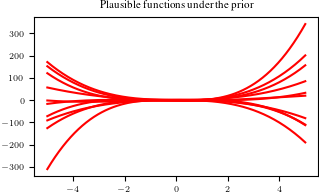

In [14]:
## EDIT THIS CELL

# samples from the prior
num_samples = 10

# We first need to generate random weights theta_i, which we sample from the parameter prior
random_weights = np.random.normal(size=(pol_deg+1,num_samples), scale=np.sqrt(prior_var))

# Now, we compute the induced random functions, evaluated at the test input locations
# Every function sample is given as f_i = Phi * theta_i,
# where theta_i is a sample from the parameter prior

sample_function = Phi_test @ random_weights # <-- SOLUTION

plt.figure()
plt.plot(Xtest, sample_function, color="r")
plt.title("Plausible functions under the prior")
print("Every sampled function is a polynomial of degree "+str(pol_deg));

Now we are given some training inputs $\boldsymbol x_1, \dotsc, \boldsymbol x_N$, which we collect in a matrix $\boldsymbol X = [\boldsymbol x_1, \dotsc, \boldsymbol x_N]^\top\in\mathbb{R}^{N\times D}$

In [15]:
N = 10
X = np.random.uniform(high=5, low=-5, size=(N,1)) # training inputs, size Nx1
y = g(X, np.sqrt(noise_var)) # training targets, size Nx1

Now, let us compute the posterior

In [16]:
## EDIT THIS FUNCTION

def polyfit(X, y, K, prior_var, noise_var):
    # X: training inputs, size N x D
    # y: training targets, size N x 1
    # K: degree of polynomial we consider
    # prior_var: prior variance of the parameter distribution
    # sigma: noise variance

    jitter = 1e-08 # increases numerical stability

    Phi = poly_features(X, K) # N x (K+1) feature matrix

    # Compute maximum likelihood estimate
    Pt = Phi.T @ y # Phi*y, size (K+1,1)
    PP = Phi.T @ Phi + jitter*np.eye(K+1) # size (K+1, K+1)
    C = scipy.linalg.cho_factor(PP)
    # maximum likelihood estimate
    theta_ml = scipy.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)

#     theta_ml = scipy.linalg.solve(PP, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)

    # MAP estimate
    theta_map = scipy.linalg.solve(PP + noise_var/prior_var*np.eye(K+1), Pt)

    # parameter posterior
    iSN = (np.eye(K+1)/prior_var + PP/noise_var) # posterior precision
    SN = scipy.linalg.pinv(noise_var*np.eye(K+1)/prior_var + PP)*noise_var  # posterior covariance
    mN = scipy.linalg.solve(iSN, Pt/noise_var) # posterior mean

    return (theta_ml, theta_map, mN, SN)

In [17]:
theta_ml, theta_map, theta_mean, theta_var = polyfit(X, y, pol_deg, alpha, sigma)

Now, let's make predictions (ignoring the measurement noise). We obtain three predictors:
\begin{align}
&\text{Maximum likelihood: }E[f(\boldsymbol X_{\text{test}})] = \boldsymbol \phi(X_{\text{test}})\boldsymbol \theta_{ml}\\
&\text{Maximum a posteriori: } E[f(\boldsymbol X_{\text{test}})] = \boldsymbol \phi(X_{\text{test}})\boldsymbol \theta_{map}\\
&\text{Bayesian: } p(f(\boldsymbol X_{\text{test}})) = \mathcal N(f(\boldsymbol X_{\text{test}}) \,|\, \boldsymbol \phi(X_{\text{test}}) \boldsymbol\theta_{\text{mean}},\, \boldsymbol\phi(X_{\text{test}}) \boldsymbol\theta_{\text{var}}  \boldsymbol\phi(X_{\text{test}})^\top)
\end{align}
We already computed all quantities. Write some code that implements all three predictors.

In [18]:
## EDIT THIS CELL

# predictions (ignoring the measurement/observations noise)

Phi_test = poly_features(Xtest, pol_deg) # N x (K+1)

# maximum likelihood predictions (just the mean)
m_mle_test = Phi_test @ theta_ml

# MAP predictions (just the mean)
m_map_test = Phi_test @ theta_map

# predictive distribution (Bayesian linear regression)
# mean prediction
mean_blr = Phi_test @ theta_mean
# variance prediction
cov_blr =  Phi_test @ theta_var @ Phi_test.T

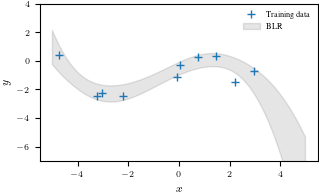

In [19]:
# plot the posterior
plt.figure()
plt.plot(X, y, "+")
# plt.plot(Xtest, m_mle_test)
# plt.plot(Xtest, m_map_test)
var_blr = np.diag(cov_blr)
conf_bound1 = np.sqrt(var_blr).flatten()
conf_bound2 = 2.0*np.sqrt(var_blr).flatten()
conf_bound3 = 2.0*np.sqrt(var_blr + sigma).flatten()

plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound1,
                 mean_blr.flatten() - conf_bound1, alpha = 0.1, color="k")
# plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound2,
#                  mean_blr.flatten() - conf_bound2, alpha = 0.1, color="k")
# plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound3,
#                  mean_blr.flatten() - conf_bound3, alpha = 0.1, color="k")
plt.legend(["Training data",  "BLR"], frameon = False)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-7, 4)
plt.savefig('blr.pdf')

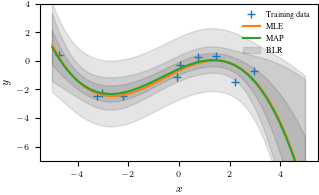

In [20]:
# plot the posterior
plt.figure()
plt.plot(X, y, "+")
plt.plot(Xtest, m_mle_test)
plt.plot(Xtest, m_map_test)
var_blr = np.diag(cov_blr)
conf_bound1 = np.sqrt(var_blr).flatten()
conf_bound2 = 2.0*np.sqrt(var_blr).flatten()
conf_bound3 = 2.0*np.sqrt(var_blr + sigma).flatten()

plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound1,
                 mean_blr.flatten() - conf_bound1, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound2,
                 mean_blr.flatten() - conf_bound2, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound3,
                 mean_blr.flatten() - conf_bound3, alpha = 0.1, color="k")
plt.legend(["Training data", "MLE", "MAP", "BLR"], frameon = False)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-7, 4)
plt.savefig('blr_mle_map.pdf')